In [4]:
!printf "1\n1\n" | gmx trjconv -s ../run/production/md.tpr -f ../run/production/md.xtc -o md_center.xtc -center -pbc mol

               :-) GROMACS - gmx trjconv, 2025.4-conda_forge (-:

Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx
Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu
Working dir:  /home/zikunye/rayca_project/PD1/analysis
Command line:
  gmx trjconv -s ../run/production/md.tpr -f ../run/production/md.xtc -o md_center.xtc -center -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file ../run/production/md.tpr, VERSION 2025.4-conda_forge (single precision)
Reading file ../run/production/md.tpr, VERSION 2025.4-conda_forge (single precision)
Select group for centering
Group     0 (         System) has 29393 elements
Group     1 (        Protein) has  1817 elements
Group     2 (      Protein-H) has   918 elements
Group     3 (        C-alpha) has   117 elements
Group     4 (       Backbone) has   351 elements
Group     5 (      MainChain) has   467

In [6]:
!printf "1\n1\n" | gmx trjconv -s ../run/production/md.tpr -f ../run/production/md.xtc -dump 0 -o prot.gro

               :-) GROMACS - gmx trjconv, 2025.4-conda_forge (-:

Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx
Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu
Working dir:  /home/zikunye/rayca_project/PD1/analysis
Command line:
  gmx trjconv -s ../run/production/md.tpr -f ../run/production/md.xtc -dump 0 -o prot.gro

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write gro: Coordinate file in Gromos-87 format
Reading file ../run/production/md.tpr, VERSION 2025.4-conda_forge (single precision)
Reading file ../run/production/md.tpr, VERSION 2025.4-conda_forge (single precision)
Select group for output
Group     0 (         System) has 29393 elements
Group     1 (        Protein) has  1817 elements
Group     2 (      Protein-H) has   918 elements
Group     3 (        C-alpha) has   117 elements
Group     4 (       Backbone) has   351 elements
Group     5 (      MainChain) has   467 elements
Group     6 (   Main

In [9]:
!ls modeller_model_aligned_out  

modeller_model_aligned.pml	 modeller_model_aligned_info.txt
modeller_model_aligned.tcl	 modeller_model_aligned_out.pdb
modeller_model_aligned_PYMOL.sh  modeller_model_aligned_pockets.pqr
modeller_model_aligned_VMD.sh	 pockets


In [12]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

info_path = Path("modeller_model_aligned_out/modeller_model_aligned_info.txt")  # change to your pockets_info.txt
text = info_path.read_text(errors="ignore")


parts = re.split(r"\bPocket\s+(\d+)\s*:\s*", text)
if len(parts) < 3:
    raise ValueError("No pockets found in fpocket output.")

pocket_ids = parts[1::2]
blocks = parts[2::2]

def to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

fields = {
    "Score": "score",
    "Druggability Score": "druggability",
    "Volume": "volume",
    "Total SASA": "sasa_total",
    "Polar SASA": "sasa_polar",
    "Apolar SASA": "sasa_apolar",
    "Hydrophobicity score": "hydrophobicity_score",
    "Polarity score": "polarity_score",
    "Flexibility": "flexibility",
    "Number of Alpha Spheres": "n_alpha_spheres",
}

def extract(block, key):
    m = re.search(rf"{re.escape(key)}\s*:\s*([-\d\.Ee+]+)", block)
    return to_float(m.group(1)) if m else np.nan

rows = []
for pid, blk in zip(pocket_ids, blocks):
    row = {"pocket_id": int(pid)}
    for k, col in fields.items():
        row[col] = extract(blk, k)
    row["apolar_sasa_frac"] = (
        row["sasa_apolar"] / row["sasa_total"]
        if (not np.isnan(row["sasa_total"]) and row["sasa_total"] > 0)
        else np.nan
    )
    rows.append(row)

df = pd.DataFrame(rows)

# Sort strictly following fpocket outputs
df_by_score = df.sort_values("score", ascending=False)
df_by_druggability = df.sort_values("druggability", ascending=False)

df_by_score.to_csv("fpocket_sorted_by_score.csv", index=False)
df_by_druggability.to_csv("fpocket_sorted_by_druggability.csv", index=False)

print("Saved:")
print("  fpocket_sorted_by_score.csv")
print("  fpocket_sorted_by_druggability.csv")

print("\nTop 5 pockets by fpocket Score:")
print(df_by_score[["pocket_id", "score", "druggability", "volume",
                   "apolar_sasa_frac", "polarity_score"]].head(5).to_string(index=False))

print("\nTop 5 pockets by Druggability Score:")
print(df_by_druggability[["pocket_id", "druggability", "score", "volume",
                          "apolar_sasa_frac", "polarity_score"]].head(5).to_string(index=False))

Saved:
  fpocket_sorted_by_score.csv
  fpocket_sorted_by_druggability.csv

Top 5 pockets by fpocket Score:
 pocket_id  score  druggability  volume  apolar_sasa_frac  polarity_score
         1  0.176         0.215 466.456          0.564917             9.0
         2  0.125         0.031 994.275          0.602885            11.0
         3  0.078         0.048 212.848          0.654574             5.0
         4  0.059         0.000 524.351          0.559708             9.0
         5  0.050         0.002 414.301          0.538925             4.0

Top 5 pockets by Druggability Score:
 pocket_id  druggability  score  volume  apolar_sasa_frac  polarity_score
         1         0.215  0.176 466.456          0.564917             9.0
         3         0.048  0.078 212.848          0.654574             5.0
         2         0.031  0.125 994.275          0.602885            11.0
         9         0.019 -0.046 312.313          0.724508             6.0
         6         0.006  0.001 271.384  

In [16]:
!ls modeller_model_aligned_out

modeller_model_aligned.pml	 modeller_model_aligned_info.txt
modeller_model_aligned.tcl	 modeller_model_aligned_out.pdb
modeller_model_aligned_PYMOL.sh  modeller_model_aligned_pockets.pqr
modeller_model_aligned_VMD.sh	 pockets


In [17]:
!ls

Untitled.ipynb			    fpocket_summary.csv		prot.gro
fpocket_sorted_by_druggability.csv  md_center.xtc
fpocket_sorted_by_score.csv	    modeller_model_aligned_out


In [63]:
%%writefile pocket_1.tcl
set pocket_pdb "modeller_model_aligned_out/pockets/pocket1_atm.pdb"
set gro_file   "prot.gro"
set xtc_file   "md_center.xtc"

set out_rgyr_atom   "pocket1_rgyr_atom.csv"

set out_rmsd_atom   "pocket1_rmsd_atom.csv"
set out_rmsd_r   "pocket1_rmsd_residue.csv"
set out_rmsd_CA   "pocket1_rmsd_CA.csv"

set out_rmsf_r "pocket1_rmsf_residue.csv"
set out_rmsf_CA   "pocket1_rmsf_CA.csv"

set out_sasa_atom_polar   "pocket1_sasa_atom_polar.csv"
set out_sasa_atom_hydrophobic   "pocket1_sasa_atom_hydrophobic.csv"
set out_sasa_residue_polar   "pocket1_sasa_residue_polar.csv"
set out_sasa_residue_hydrophobic   "pocket1_sasa_residue_hydrophobic.csv"

set dt 0.01
set prod_size 1.4

set pm [mol new $pocket_pdb]
set ps [atomselect $pm all]
set presid [$ps get resid]
set pname [$ps get name]

set traj [mol new $gro_file type gro waitfor all]
mol addfile $xtc_file type xtc waitfor all
set nframes [molinfo $traj get numframes]

set pid {}
foreach n $pname r $presid {
    set tmpsel [atomselect $traj "protein and resid $r and name $n"]
    lappend pid [$tmpsel get index]
}
set presid [lsort -u $presid]

# pocket atom rgyr
set sel [atomselect $traj "index $pid"]
set f [open $out_rgyr_atom w]
puts $f "frame,time,rgyr_A"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    set rgyr [measure rgyr $sel weight mass]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$rgyr"
}
close $f
exit

# pocket atom align
set sel [atomselect $traj "index $pid"]
set all [atomselect $traj all]
set ref [atomselect $traj "index $pid" frame 0]

# ====== RMSD ======
puts "starting RMSD analysis with pocket atoms aligned"
set f [open $out_rmsd_atom w]
puts $f "frame,time,rmsd_A"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $all frame $i
    # Fit pocket atoms of frame i to pocket atoms of frame 0
    set T [measure fit $sel $ref]
    $all move $T

    set rmsd [measure rmsd $sel $ref]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$rmsd"
}
close $f

# pocket CA align
set sel [atomselect $traj "name CA and same residue as (index $pid)"]
set all [atomselect $traj all]
set ref [atomselect $traj "name CA and same residue as (index $pid)" frame 0]

# ====== RMSD ======
puts "starting RMSD analysis with pocket CA aligned"
set f [open $out_rmsd_CA w]
puts $f "frame,time,rmsd_A"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $all frame $i
    # Fit pocket atoms of frame i to pocket atoms of frame 0
    set T [measure fit $sel $ref]
    $all move $T

    set rmsd [measure rmsd $sel $ref]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$rmsd"
}
close $f
# ====== RMSF ======
puts "starting RMSF analysis with pocket CA aligned"
set f [open $out_rmsf_CA w]
puts $f "resid,rmsf_A"
foreach r $presid {
    set tmpsel [atomselect $traj "protein and resid $r and name CA"]
    set rmsf  [measure rmsf $tmpsel]
    puts $f "$r,$rmsf"
}
close $f

# pocket residue align
set sel [atomselect $traj "noh same residue as (index $pid)"]
set all [atomselect $traj all]
set ref [atomselect $traj "noh same residue as (index $pid)" frame 0]

# ====== RMSD ======
puts "starting RMSD analysis with pocket residue aligned"
set f [open $out_rmsd_r w]
puts $f "frame,time,rmsd_A"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $all frame $i
    # Fit pocket atoms of frame i to pocket atoms of frame 0
    set T [measure fit $sel $ref]
    $all move $T

    set rmsd [measure rmsd $sel $ref]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$rmsd"
}
close $f
# ====== RMSF ======
puts "starting RMSF analysis with pocket residue aligned"
set f [open $out_rmsf_r w]
puts $f "resid,rmsf_A"
foreach r $presid {
    set tmpsel [atomselect $traj "protein and resid $r and noh"]
    set rmsf [expr ([join [measure rmsf $tmpsel] +]) / [$tmpsel num]]
    puts $f "$r,$rmsf"
}
close $f

# pocket SASA hydrophobic
puts "starting pocket residue hydrophobic SASA"
set sel [atomselect $traj "noh protein"]
set restrict_sel [atomselect $traj "noh and name \"^C.*\" and same residue as index $pid"]
set f [open $out_sasa_residue_hydrophobic w]
puts $f "frame,time,sasa_A2"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $restrict_sel frame $i
    set sasa [measure sasa $prod_size $sel -restrict $restrict_sel ]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$sasa"
}
close $f

# pocket SASA polar
puts "starting pocket residue polar SASA"
set sel [atomselect $traj "noh protein"]
set restrict_sel [atomselect $traj "noh and not  name \"^C.*\" and same residue as index $pid"]
set f [open $out_sasa_residue_polar w]
puts $f "frame,time,sasa_A2"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $restrict_sel frame $i
    set sasa [measure sasa $prod_size $sel -restrict $restrict_sel ]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$sasa"
}
close $f

# pocket SASA hydrophobic
puts "starting pocket atom hydrophobic SASA"
set sel [atomselect $traj "noh protein"]
set restrict_sel [atomselect $traj " name \"^C.*\" and index $pid"]
set f [open $out_sasa_atom_hydrophobic w]
puts $f "frame,time,sasa_A2"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $restrict_sel frame $i
    set sasa [measure sasa $prod_size $sel -restrict $restrict_sel ]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$sasa"
}
close $f

# pocket SASA polar
puts "starting pocket atom polar SASA"
set sel [atomselect $traj "noh protein"]
set restrict_sel [atomselect $traj "not  name \"^C.*\" and index $pid"]
set f [open $out_sasa_atom_polar w]
puts $f "frame,time,sasa_A2"
for {set i 0} {$i < $nframes} {incr i} {
    $sel frame $i
    $restrict_sel frame $i
    set sasa [measure sasa $prod_size $sel -restrict $restrict_sel ]
    set t [expr {$i * $dt}]
    puts $f "$i,$t,$sasa"
}
close $f

Overwriting pocket_1.tcl


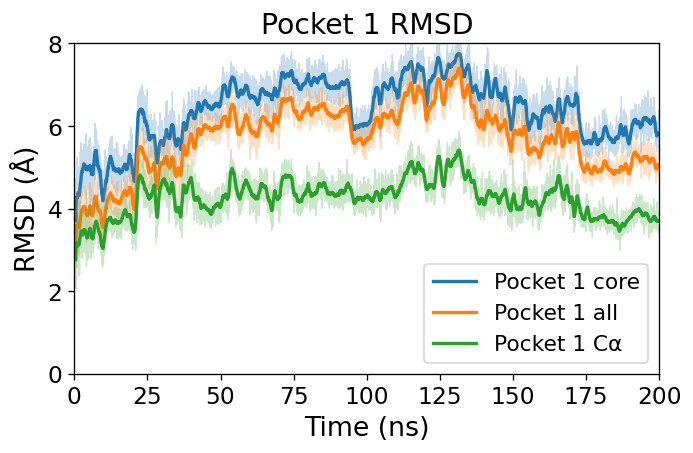

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 14,          # base font
    "axes.labelsize": 16,     # x/y label
    "axes.titlesize": 17,     # title
    "xtick.labelsize": 14,    # x tick labels
    "ytick.labelsize": 14,    # y tick labels
    "legend.fontsize": 13,
    "lines.linewidth": 2.0,
})

# -------- parameters --------
window = 100   # moving average window (frames)

# -------- load data --------
df_atom = pd.read_csv("pocket1_rmsd_atom.csv")
df_ca   = pd.read_csv("pocket1_rmsd_CA.csv")
df_res  = pd.read_csv("pocket1_rmsd_residue.csv")

# -------- compute moving averages --------
df_atom["rmsd_ma"] = df_atom["rmsd_A"].rolling(window, center=True).mean()
df_ca["rmsd_ma"]   = df_ca["rmsd_A"].rolling(window, center=True).mean()
df_res["rmsd_ma"]  = df_res["rmsd_A"].rolling(window, center=True).mean()

# -------- plot --------
plt.figure(figsize=(6,4))

# Atom-level
plt.plot(df_atom["time"], df_atom["rmsd_A"],
         color="tab:blue", alpha=0.25, lw=0.8)
plt.plot(df_atom["time"], df_atom["rmsd_ma"],
         color="tab:blue", lw=2.0,
         label="Pocket 1 core")

# Residue-averaged
plt.plot(df_res["time"], df_res["rmsd_A"],
         color="tab:orange", alpha=0.25, lw=0.8)
plt.plot(df_res["time"], df_res["rmsd_ma"],
         color="tab:orange", lw=2.0,
         label="Pocket 1 all")

# CA-based
plt.plot(df_ca["time"], df_ca["rmsd_A"],
         color="tab:green", alpha=0.25, lw=0.8)
plt.plot(df_ca["time"], df_ca["rmsd_ma"],
         color="tab:green", lw=2.0,
         label="Pocket 1 Cα")

plt.xlabel("Time (ns)")
plt.ylabel("RMSD (Å)")
plt.xlim(0,200)
plt.ylim(0,8)
plt.title("Pocket 1 RMSD")
plt.legend(frameon=True, loc='best')
plt.tight_layout()

plt.savefig(
    "pocket1_rmsd.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

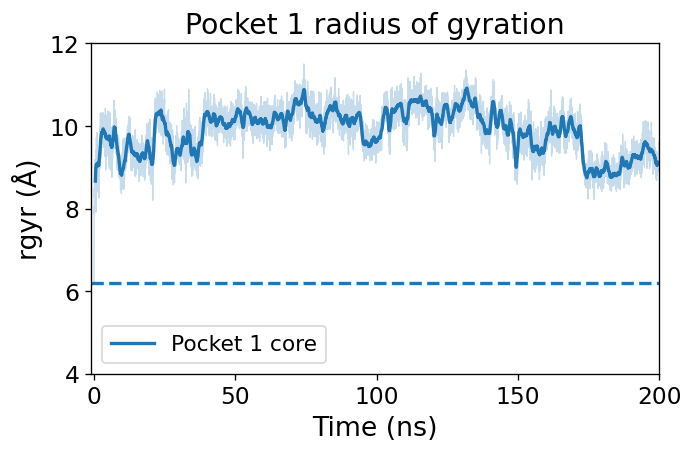

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 14,          # base font
    "axes.labelsize": 16,     # x/y label
    "axes.titlesize": 17,     # title
    "xtick.labelsize": 14,    # x tick labels
    "ytick.labelsize": 14,    # y tick labels
    "legend.fontsize": 13,
    "lines.linewidth": 2.0,
})

# -------- parameters --------
window = 100   # moving average window (frames)

# -------- load data --------
df_atom = pd.read_csv("pocket1_rgyr_atom.csv")


# -------- compute moving averages --------
df_atom["rgyr_ma"] = df_atom["rgyr_A"].rolling(window, center=True).mean()


# -------- plot --------
plt.figure(figsize=(6,4))

# Atom-level
plt.plot(df_atom["time"], df_atom["rgyr_A"],
         color="tab:blue", alpha=0.25, lw=0.8)
plt.plot(df_atom["time"], df_atom["rgyr_ma"],
         color="tab:blue", lw=2.0,
         label="Pocket 1 core")

plt.axhline(y=df_atom["rgyr_A"][0],linestyle="--")

plt.xlabel("Time (ns)")
plt.ylabel("rgyr (Å)")
plt.xlim(-1,200)
plt.ylim(4,12)
plt.title("Pocket 1 radius of gyration")
plt.legend(frameon=True, loc='best')
plt.tight_layout()
plt.savefig(
    "pocket1_rgyr.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

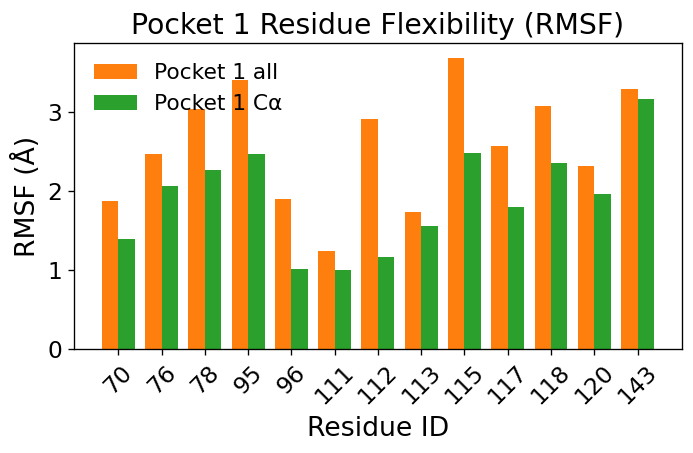

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 17,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 13,
    "lines.linewidth": 2.0,
})

df_ca  = pd.read_csv("pocket1_rmsf_CA.csv")        # columns: resid,rmsf_A
df_res = pd.read_csv("pocket1_rmsf_residue.csv")   # columns: resid,rmsf_A


# Sort by resid
df_ca  = df_ca.sort_values("resid")
df_res = df_res.sort_values("resid")

resids = df_ca["resid"].values
x = np.arange(len(resids))
bar_w = 0.38

# -------- plot --------
plt.figure(figsize=(6.0,4))

# Residue-average RMSF (orange)
plt.bar(x - bar_w/2, df_res["rmsf_A"].values,
        width=bar_w, color="tab:orange",
        label="Pocket 1 all")

# CA RMSF (green)
plt.bar(x + bar_w/2, df_ca["rmsf_A"].values,
        width=bar_w, color="tab:green",
        label="Pocket 1 Cα")

plt.xlabel("Residue ID")
plt.ylabel("RMSF (Å)")
plt.title("Pocket 1 Residue Flexibility (RMSF)")

plt.xticks(x, resids, rotation=45)
plt.legend(frameon=False)
plt.tight_layout()

# -------- save --------
#plt.savefig("pocket1_rmsf_bar.png", dpi=300, bbox_inches="tight")
plt.savefig("pocket1_rmsf_bar.pdf", bbox_inches="tight")

plt.show()

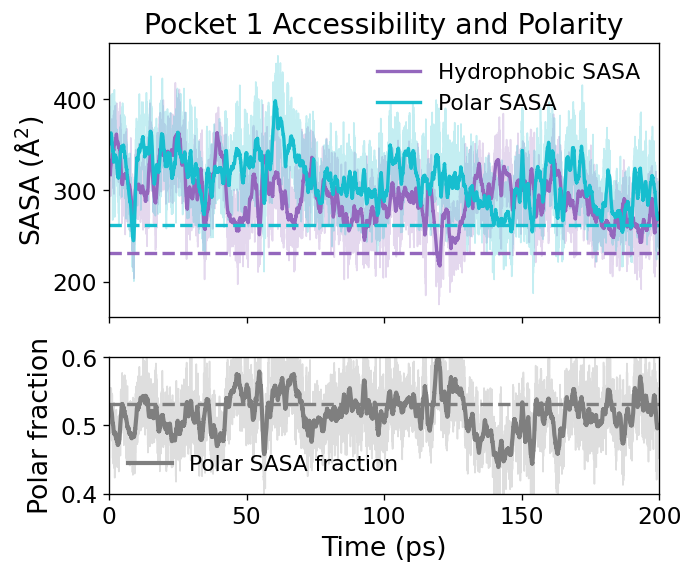

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 17,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 13,
    "lines.linewidth": 2.0,
})

# -------- parameters --------
window = 100

# -------- load data --------
df_h = pd.read_csv("pocket1_sasa_atom_hydrophobic.csv")  # time,sasa
df_p = pd.read_csv("pocket1_sasa_atom_polar.csv")        # time,sasa

def find_sasa_col(df):
    for c in ["sasa_A2", "sasa", "SASA", "SASA_A2"]:
        if c in df.columns:
            return c
    return [c for c in df.columns if c.lower() not in ["frame", "time"]][0]

col_h = find_sasa_col(df_h)
col_p = find_sasa_col(df_p)

df = pd.merge(
    df_h[["time", col_h]],
    df_p[["time", col_p]],
    on="time",
    how="inner"
)

df = df.rename(columns={
    "sasa_A2_x": "hydrophobic",
    "sasa_A2_y": "polar"
})


df["polar_frac"] = df["polar"] / (df["polar"] + df["hydrophobic"] + 1e-12)

# moving averages
df["hydrophobic_ma"] = df["hydrophobic"].rolling(window, center=True).mean()
df["polar_ma"]       = df["polar"].rolling(window, center=True).mean()
df["polar_frac_ma"]  = df["polar_frac"].rolling(window, center=True).mean()

# -------- plot --------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 5.0), sharex=True,
    gridspec_kw={"height_ratios": [2, 1]}
)

# colors
c_h = "tab:purple"
c_p = "tab:cyan"
c_f = "tab:gray"

# Panel A: SASA
ax1.plot(df["time"], df["hydrophobic"], color=c_h, alpha=0.25, lw=1.0)
ax1.plot(df["time"], df["polar"],       color=c_p, alpha=0.25, lw=1.0)

ax1.plot(df["time"], df["hydrophobic_ma"], color=c_h, lw=2.,
         label="Hydrophobic SASA")
ax1.plot(df["time"], df["polar_ma"],       color=c_p, lw=2.,
         label="Polar SASA")

ax1.axhline(y=df["hydrophobic"][0],linestyle="--",color=c_h)
ax1.axhline(y=df["polar"][0],linestyle="--",color=c_p)


ax1.set_ylabel("SASA (Å$^2$)")
ax1.set_title("Pocket 1 Accessibility and Polarity")
ax1.set_xlim(0, 200)
ax1.legend(frameon=False)

# Panel B: Polar fraction
ax2.plot(df["time"], df["polar_frac"],    color=c_f, alpha=0.25, lw=1.0)
ax2.plot(df["time"], df["polar_frac_ma"], color=c_f, lw=2.5,
         label="Polar SASA fraction")

ax2.axhline(y=df["polar_frac"][0],linestyle="--",color=c_f)

ax2.set_xlabel("Time (ps)")
ax2.set_ylabel("Polar fraction")
ax2.set_xlim(0, 200)
ax2.set_ylim(0.4, 0.6)
ax2.legend(frameon=False)

plt.tight_layout()

#plt.savefig("pocket1_sasa_polarfrac.png", dpi=300, bbox_inches="tight")
plt.savefig("pocket1_sasa_polarfrac.pdf", bbox_inches="tight")
plt.show()